# Bibliotecas e Carregemento do Dataset

In [194]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

Funções Prontas

In [195]:
def calcular_media(valores):
    return sum(valores) / len(valores)


def calcular_media_ponderada(valores, pesos):
    return sum(v * p for v, p in zip(valores, pesos)) / sum(pesos)


def calcular_media_truncada(valores, proporcao_remover):
    valores_ordenados = sorted(valores)
    n_remover = int(len(valores) * proporcao_remover)
    valores_truncados = valores_ordenados[n_remover:len(valores) - n_remover]
    return sum(valores_truncados) / len(valores_truncados)


def calcular_mediana(valores):
    valores_ordenados = sorted(valores)
    n = len(valores)
    meio = n // 2
    if n % 2 == 0:
        return (valores_ordenados[meio - 1] + valores_ordenados[meio]) / 2
    else:
        return valores_ordenados[meio]

def encontrar_outliers(valores, ajuste): #ajuste 1.1, 1.2
    # Ordenar os valores
    valores_ordenados = sorted(valores)

    # Encontrar Q1 (25º percentil) e Q3 (75º percentil)
    q1 = calcular_mediana(valores_ordenados[:len(valores_ordenados) // 2])
    q3 = calcular_mediana(valores_ordenados[len(valores_ordenados) // 2:])

    # Calcular IQR (Intervalo entre Quartis)
    iqr = q3 - q1

    # Definir limites para outliers
    limite_inferior = q1 - ajuste * iqr
    limite_superior = q3 + ajuste * iqr

    # Encontrar os outliers
    outliers = [v for v in valores if v < limite_inferior or v > limite_superior]
    return outliers



# Função para calcular a variância
def calcular_variancia(dados, media):
    return sum((x - media) ** 2 for x in dados) / len(dados)

# Função para calcular o desvio padrão
def calcular_desvio_padrao(variancia):
    return variancia ** 0.5

# Função para calcular a correlação de Pearson
def calcular_correlacao(x, y):
    # Calcular a média de x e y
    media_x = calcular_media(x)
    media_y = calcular_media(y)

    # Calcular a variância de x e y
    variancia_x = calcular_variancia(x, media_x)
    variancia_y = calcular_variancia(y, media_y)

    # Calcular o desvio padrão de x e y
    desvio_x = calcular_desvio_padrao(variancia_x)
    desvio_y = calcular_desvio_padrao(variancia_y)

    # Calcular a covariância
    covariancia = sum((x[i] - media_x) * (y[i] - media_y) for i in range(len(x))) / len(x)

    # Calcular a correlação de Pearson
    return covariancia / (desvio_x * desvio_y)

# Calculando a matriz de correlação entre todos os pares de atributos
def calcular_matriz_correlacao(df):
  atributos = df.columns
  matriz_correlacao = pd.DataFrame(index=atributos, columns=atributos)
  for i in range(len(atributos)):
      for j in range(i, len(atributos)):
          atributo_x = atributos[i]
          atributo_y = atributos[j]

          # Calculando a correlação entre os atributos
          correlacao = calcular_correlacao(df[atributo_x], df[atributo_y])

          # Preenchendo a matriz de correlação
          matriz_correlacao.loc[atributo_x, atributo_y] = correlacao
          matriz_correlacao.loc[atributo_y, atributo_x] = correlacao  # Matriz é simétrica

  # retorna a matriz de correlação
  return matriz_correlacao

def plot_matriz_correlacao(matriz_correlacao):
  # Visualizando a matriz de correlação com um heatmap
  plt.figure(figsize=(8, 6))
  sns.heatmap(matriz_correlacao.astype(float), annot=True, cmap='coolwarm', vmin=-1, vmax=1)
  plt.xticks(fontsize=12)
  plt.yticks(fontsize=12)
  plt.title('Matriz de Correlação')
  plt.show()

def plt_matriz_disperscao(df):
  # Gráfico de dispersão (scatter plot) entre todas as combinações de atributos
  atributos = df.columns

  # Criando a matriz de gráficos de dispersão usando pairplot do Seaborn
  sns.pairplot(df)
  plt.suptitle('Gráficos de Dispersão entre Atributos', y=1.02)  # Título para o gráfico
  plt.show()

def plt_hist(dados, nome_coluna, bins=5):
    # Criando o histograma
    plt.hist(dados, bins, edgecolor='black')  # bins define o número de intervalos

    # Adicionando título e rótulos dos eixos
    plt.title(f'Histograma de {nome_coluna}')
    plt.xlabel('Valores')
    plt.ylabel('Frequência')

    # Exibindo o histograma
    plt.show()

In [196]:
df = pd.read_csv('ds_salaries.csv', index_col=0)
#df['Target'] = df['salary_in_usd']
df

,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
0,2020,MI,FT,Data Scientist,70000,EUR,79833,DE,0,DE,L
1,2020,SE,FT,Machine Learning Scientist,260000,USD,260000,JP,0,JP,S
2,2020,SE,FT,Big Data Engineer,85000,GBP,109024,GB,50,GB,M
3,2020,MI,FT,Product Data Analyst,20000,USD,20000,HN,0,HN,S
4,2020,SE,FT,Machine Learning Engineer,150000,USD,150000,US,50,US,L
...,...,...,...,...,...,...,...,...,...,...,...
602,2022,SE,FT,Data Engineer,154000,USD,154000,US,100,US,M
603,2022,SE,FT,Data Engineer,126000,USD,126000,US,100,US,M
604,2022,SE,FT,Data Analyst,129000,USD,129000,US,0,US,M
605,2022,SE,FT,Data Analyst,150000,USD,150000,US,100,US,M


O dataset Data Science Job Salaries traz como problemática o salário de empregos na área de Ciência de Dados. Ele possui 12 atributos, como cargo, experiência, nível de educação, tipo de emprego, tamanho da empresa, localização e salário. Possui 607 instâncias. O dataset visa fornecer insights sobre os salários na área de Ciência de Dados, permitindo a análise de fatores que influenciam a remuneração, como experiência, localização e tamanho da empresa.

Atributos:

work_year: Ano em que o salário foi pago.

experience_level: Nível de experiência do profissional (EN, MI, SE, EX).

employment_type: Tipo de emprego (PT, FT, CT, FL).

job_title: Cargo do profissional.

salary: Salário anual em USD.

salary_currency: Moeda em que o salário foi pago.

salary_in_usd: Salário anual em USD convertido.

employee_residence: País de residência do profissional.

remote_ratio: Porcentagem de trabalho remoto.

company_location: País da empresa.

company_size: Tamanho da empresa (S, M, L).

# Cálculos

In [197]:
# Calcular as estimativas de localização para cada atributo numérico
for coluna in df.select_dtypes(include=np.number).columns:
    print(f"Atributo: {coluna}")

    # Média
    print(f"  Média: {df[coluna].mean()}")

    # Mediana
    print(f"  Mediana: {df[coluna].median()}")

    # Moda
    print(f"  Moda: {df[coluna].mode()[0]}")  # Pode haver mais de uma moda

    # Outliers (ajuste 1.5)
    valores = df[coluna].tolist()
    outliers = encontrar_outliers(valores, 1.5)
    print(f"  Outliers: {outliers}")

    print("\n")

# Calcular a moda para atributos categóricos
for coluna in df.select_dtypes(include=['object']).columns:
    print(f"Atributo: {coluna}")

    # Moda
    print(f"  Moda: {df[coluna].mode()[0]}")

    print("\n")

Atributo: work_year
  Média: 2021.4052718286655
  Mediana: 2022.0
  Moda: 2022
  Outliers: []


Atributo: salary
  Média: 324000.0626029654
  Mediana: 115000.0
  Moda: 80000
  Outliers: [11000000, 3000000, 4450000, 423000, 450000, 325000, 720000, 450000, 450000, 412000, 400000, 1450000, 2200000, 450000, 11000000, 2250000, 700000, 3000000, 7000000, 8500000, 423000, 30400000, 420000, 1672000, 1799997, 4000000, 435000, 2500000, 416000, 1200000, 1600000, 1335000, 600000, 2100000, 1250000, 4900000, 7000000, 6000000, 1400000, 2400000, 1400000, 324000, 380000, 405000]


Atributo: salary_in_usd
  Média: 112297.86985172982
  Mediana: 101570.0
  Moda: 100000
  Outliers: [325000, 450000, 412000, 450000, 423000, 416000, 600000, 324000, 380000, 405000]


Atributo: remote_ratio
  Média: 70.92257001647447
  Mediana: 100.0
  Moda: 100
  Outliers: []


Atributo: experience_level
  Moda: SE


Atributo: employment_type
  Moda: FT


Atributo: job_title
  Moda: Data Scientist


Atributo: salary_currency
  

In [198]:
# Calcular as estimativas de variabilidade para cada atributo numérico
for coluna in df.select_dtypes(include=np.number).columns:
    print(f"Atributo: {coluna}")

    # Variância
    variancia = calcular_variancia(df[coluna].tolist(), df[coluna].mean())
    print(f"  Variância: {variancia}")

    # Desvio Padrão
    desvio_padrao = calcular_desvio_padrao(variancia)
    print(f"  Desvio Padrão: {desvio_padrao}")

    # Percentil 25
    percentil_25 = np.percentile(df[coluna], 25)
    print(f"  Percentil 25: {percentil_25}")

    # Percentil 75
    percentil_75 = np.percentile(df[coluna], 75)
    print(f"  Percentil 75: {percentil_75}")

    print("\n")

Atributo: work_year
  Variância: 0.47825886350621105
  Desvio Padrão: 0.6915626244283384
  Percentil 25: 2021.0
  Percentil 75: 2022.0


Atributo: salary
  Variância: 2381110820751.388
  Desvio Padrão: 1543084.8391295238
  Percentil 25: 70000.0
  Percentil 75: 165000.0


Atributo: salary_in_usd
  Variância: 5026637881.193936
  Desvio Padrão: 70898.78617574448
  Percentil 25: 62726.0
  Percentil 75: 150000.0


Atributo: remote_ratio
  Variância: 1654.5030655531823
  Desvio Padrão: 40.67558316180829
  Percentil 25: 50.0
  Percentil 75: 100.0




# Análise Exploratoria

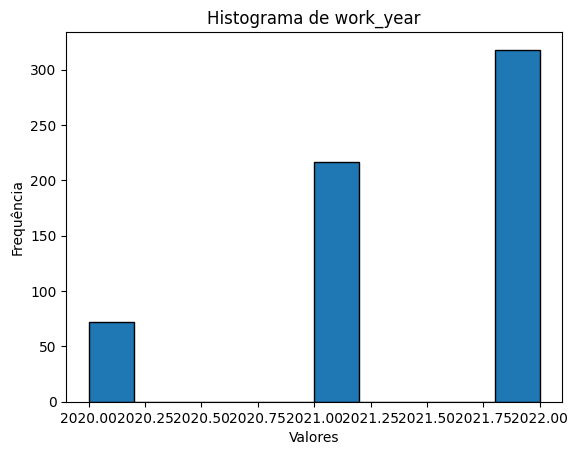

Análise da distribuição de work_year:




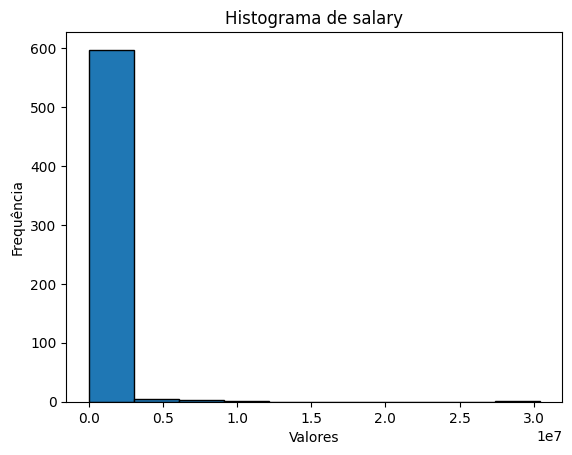

Análise da distribuição de salary:




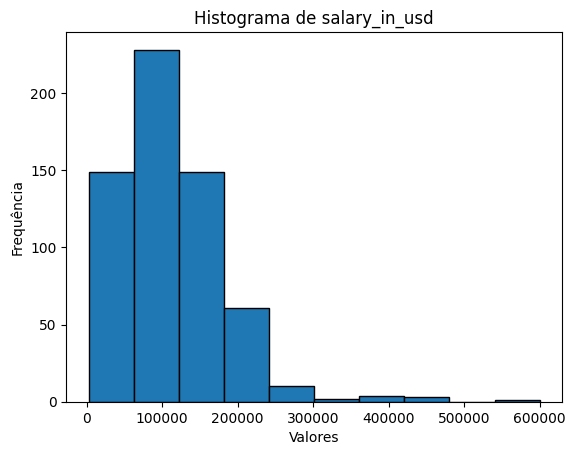

Análise da distribuição de salary_in_usd:




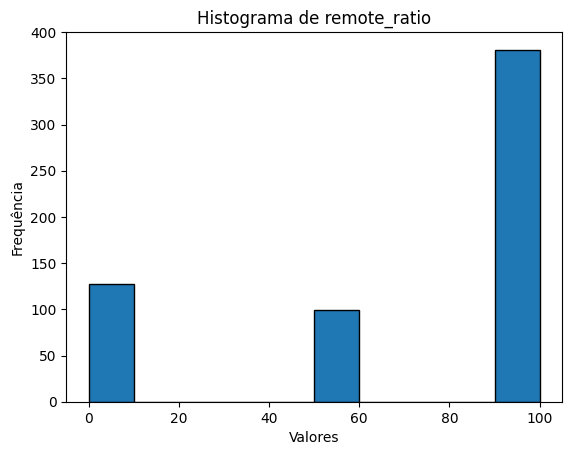

Análise da distribuição de remote_ratio:




In [203]:
# Iterar sobre as colunas numéricas do DataFrame
for coluna in df.select_dtypes(include=np.number).columns:

    # Gerar o histograma usando a função plt_hist
    plt_hist(df[coluna], coluna,bins=10)  # Ajuste o número de bins se necessário

    # Imprimir informações sobre a distribuição (opcional)
    print(f"Análise da distribuição de {coluna}:")

    # Aqui você pode adicionar a análise da distribuição
    # com base na forma do histograma, como no exemplo anterior:
    # - Uniforme
    # - Simétrica
    # - Assimétrica à direita/esquerda
    # - Dissimétrica

    # Você também pode usar as funções auxiliares
    # (calcular_media, calcular_mediana, etc.)
    # para complementar a análise, se desejar.

    print("\n")  # Separar as informações de cada coluna

              work_year    salary salary_in_usd remote_ratio
work_year           1.0 -0.087577      0.170493     0.076314
salary        -0.087577       1.0     -0.083906    -0.014608
salary_in_usd  0.170493 -0.083906           1.0     0.132122
remote_ratio   0.076314 -0.014608      0.132122          1.0


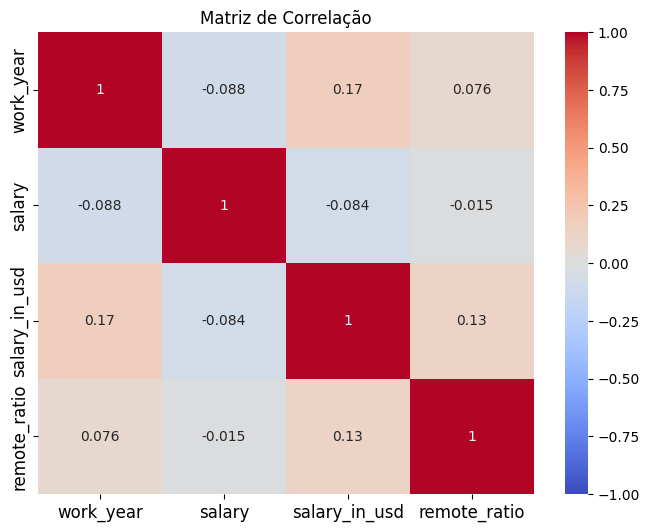

In [204]:
# Seleciona apenas as colunas numéricas
df_numerico = df.select_dtypes(include=np.number)

# Calcula a matriz de correlação
matriz_correlacao = calcular_matriz_correlacao(df_numerico)

# Exibe a matriz de correlação
print(matriz_correlacao)

# Visualiza a matriz de correlação com um heatmap
plot_matriz_correlacao(matriz_correlacao)


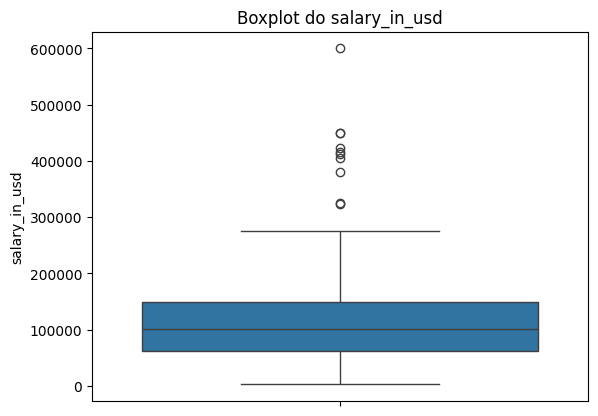

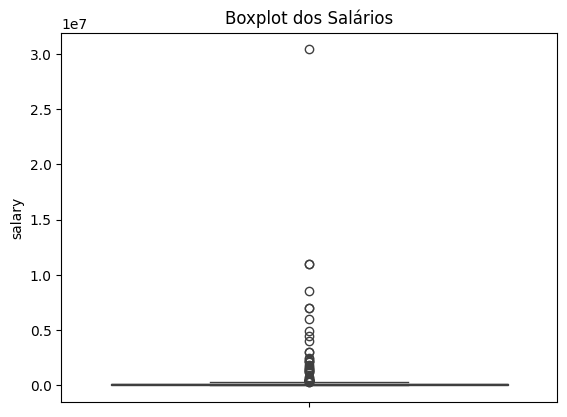

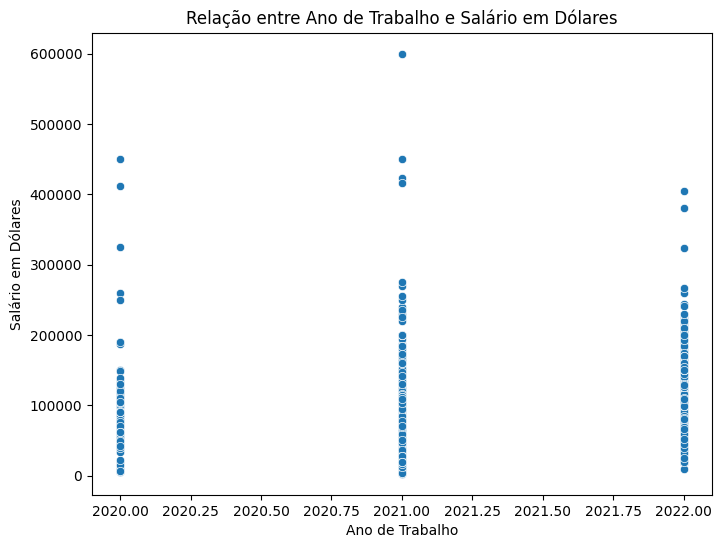

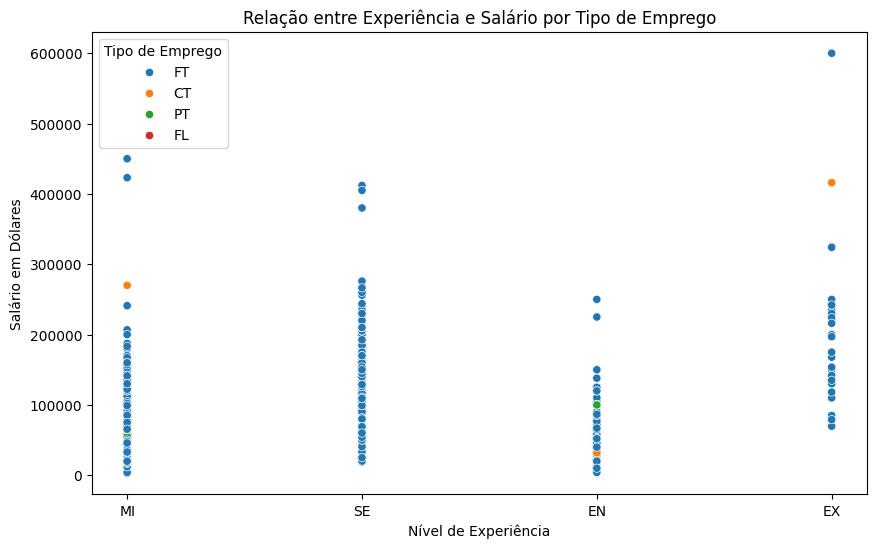

In [205]:
# Boxplot das variáveis continuas salary e salary_in_usd
sns.boxplot(data=df, y='salary_in_usd')
plt.title("Boxplot do salary_in_usd")
plt.show()

sns.boxplot(data=df, y='salary')
plt.title("Boxplot dos Salários")
plt.show()

# Gráfico de dispersão entre 'work_year' e 'salary_in_usd'
plt.figure(figsize=(8, 6))
sns.scatterplot(x='work_year', y='salary_in_usd', data=df)
plt.title('Relação entre Ano de Trabalho e Salário em Dólares')
plt.xlabel('Ano de Trabalho')
plt.ylabel('Salário em Dólares')
plt.show()

# Gráfico de dispersão entre 'experience_level' e 'salary_in_usd', com 'employment_type' como hue
plt.figure(figsize=(10, 6))
sns.scatterplot(x='experience_level', y='salary_in_usd', hue='employment_type', data=df)
plt.title('Relação entre Experiência e Salário por Tipo de Emprego')
plt.xlabel('Nível de Experiência')
plt.ylabel('Salário em Dólares')
plt.legend(title='Tipo de Emprego')
plt.show()


# Conversão de Atributos

In [206]:
# Conversão dos atributos categóricos

def convert_experience_level(df):
  for i in df.index:
    if df.at[i,'experience_level'] == 'EN':
      df.at[i,'experience_level'] = 0  # Entry-level
    elif df.at[i,'experience_level'] == 'MI':
      df.at[i,'experience_level'] = 1  # Mid-level
    elif df.at[i,'experience_level'] == 'SE':
      df.at[i,'experience_level'] = 2  # Senior-level
    elif df.at[i,'experience_level'] == 'EX':
      df.at[i,'experience_level'] = 3  # Executive-level
  return df

def convert_employment_type(df):
  for i in df.index:
    if df.at[i,'employment_type'] == 'PT':
      df.at[i,'employment_type'] = 0  # Part-time
    elif df.at[i,'employment_type'] == 'FT':
      df.at[i,'employment_type'] = 1  # Full-time
    elif df.at[i,'employment_type'] == 'CT':
      df.at[i,'employment_type'] = 2  # Contract
    elif df.at[i,'employment_type'] == 'FL':
      df.at[i,'employment_type'] = 3  # Freelance
  return df

def convert_job_title(df):
    unique_job_titles = df['job_title'].unique()
    job_title_mapping = {title: i for i, title in enumerate(unique_job_titles)}
    df['job_title'] = df['job_title'].map(job_title_mapping)
    return df

def convert_salary_currency(df):
    unique_currencies = df['salary_currency'].unique()
    currency_mapping = {currency: i for i, currency in enumerate(unique_currencies)}
    df['salary_currency'] = df['salary_currency'].map(currency_mapping)
    return df

def convert_employee_residence(df):
    unique_residences = df['employee_residence'].unique()
    residence_mapping = {residence: i for i, residence in enumerate(unique_residences)}
    df['employee_residence'] = df['employee_residence'].map(residence_mapping)
    return df

def convert_company_location(df):
    unique_locations = df['company_location'].unique()
    location_mapping = {location: i for i, location in enumerate(unique_locations)}
    df['company_location'] = df['company_location'].map(location_mapping)
    return df

def convert_company_size(df):
  for i in df.index:
    if df.at[i,'company_size'] == 'S':
      df.at[i,'company_size'] = 0  # Small
    elif df.at[i,'company_size'] == 'M':
      df.at[i,'company_size'] = 1  # Medium
    elif df.at[i,'company_size'] == 'L':
      df.at[i,'company_size'] = 2  # Large
  return df





In [207]:
# Aplica as funções ao DataFrame 'df'
df = convert_experience_level(df)
df = convert_employment_type(df)
df = convert_job_title(df)
df = convert_salary_currency(df)
df = convert_employee_residence(df)
df = convert_company_location(df)
df = convert_company_size(df)



# Treinamento e Execução

In [209]:

# Divisão entre atributos (X) e alvo (y)
X = df.drop('salary_in_usd', axis=1)
y = df['salary_in_usd']


In [210]:
# Divisão em conjunto de treinamento (70%) e teste (30%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [212]:
# Lista de modelos para teste
models = {
    "Decision Tree": DecisionTreeRegressor(random_state=42, splitter = 'best', max_depth=10,min_samples_split=10, min_samples_leaf=5),
    "MLP Regressor": MLPRegressor(
        hidden_layer_sizes=(128, 64),
      activation='relu',
      alpha=0.001,
      learning_rate_init= 0.01,
        max_iter=1000,
      random_state=42
    )
}

# Dicionário para armazenar os resultados
results = {}

# Treinamento, predição e cálculo do erro médio quadrático (MSE) e R-squared
for name, model in models.items():
    try:
        model.fit(X_train, y_train)
        predictions = model.predict(X_test)
        mse = mean_squared_error(y_test, predictions)
        r2 = r2_score(y_test, predictions)
        mae = mean_absolute_error(y_test, predictions) # Calcule o MAE

        results[name] = {
            "model": model,
            "mse": mse,
            "r2": r2,
            "mae": mae, # Armazene o MAE nos resultados
            "predictions": predictions
        }
        print(f"{name} - MSE: {mse:.4f}, R-squared: {r2:.4f}, MAE: {mae:.4f}")  # Imprima o MAE
    except Exception as e:
        print(f"{name} - Error: {e}")

# Ordenar modelos pelo MSE
sorted_results = sorted(results.items(), key=lambda x: x[1]['mse'])


Decision Tree - MSE: 156768707.0644, R-squared: 0.9665, MAE: 6204.2396
MLP Regressor - MSE: 6297132224.6580, R-squared: -0.3441, MAE: 52535.0594


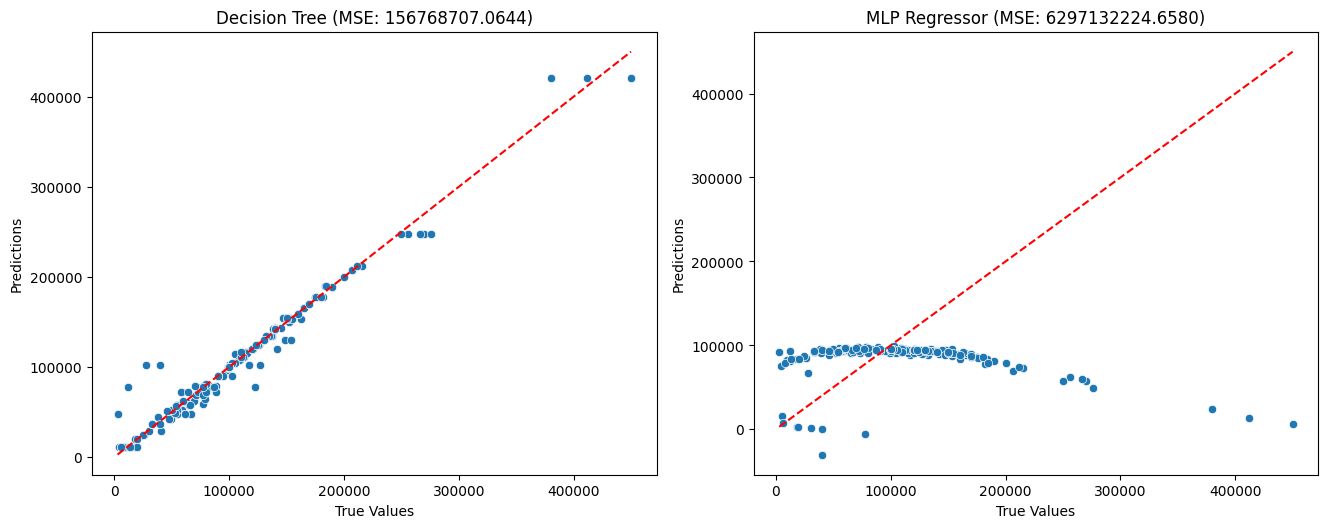

In [213]:
# Gráficos scatter plot para cada modelo separadamente
plt.figure(figsize=(20, 20))
for i, (name, res) in enumerate(sorted_results, 1):
    plt.subplot(4, 3, i)
    sns.scatterplot(x=y_test, y=res['predictions'])
    plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')
    plt.title(f"{name} (MSE: {res['mse']:.4f})")
    plt.xlabel("True Values")
    plt.ylabel("Predictions")

plt.tight_layout()
plt.show()

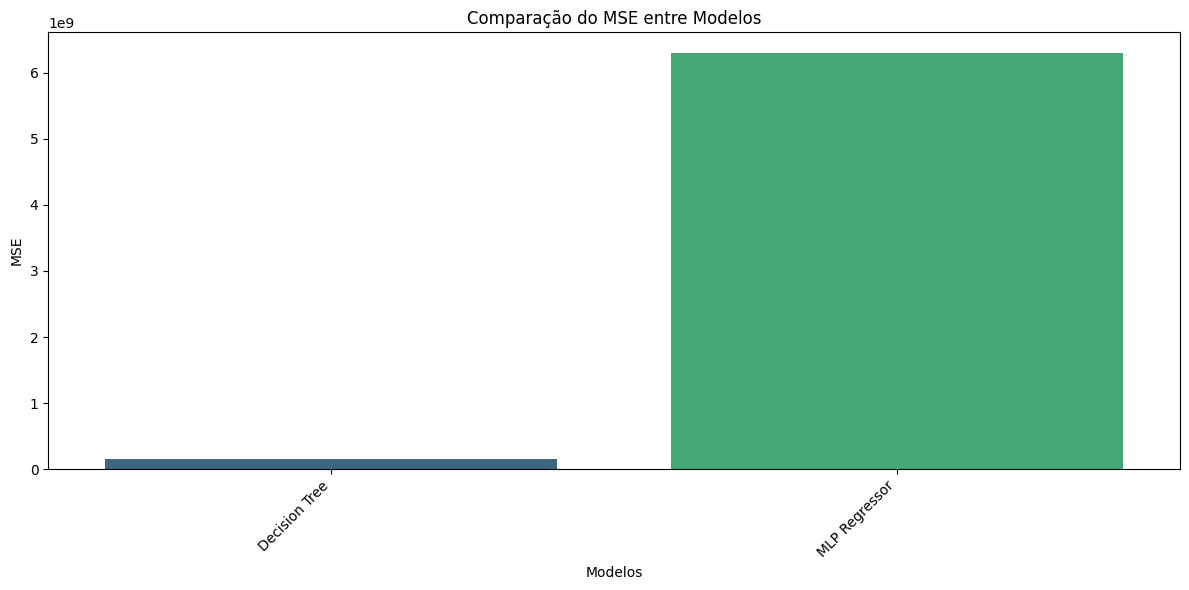

In [214]:
# Gráfico para comparar MSE dos modelos
plt.figure(figsize=(12, 6))
model_names = [name for name, res in sorted_results]
model_mse = [res['mse'] for name, res in sorted_results]
sns.barplot(x=model_names, y=model_mse, palette="viridis")
plt.title("Comparação do MSE entre Modelos")
plt.xlabel("Modelos")
plt.ylabel("MSE")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

